In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
import glob

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

In [87]:
results_root_dir=os.path.join(os.environ['HOME'],'agentfil','exp')

fil_supply_discount_rate = 30

rational_agent_type='NPVAgent'
sdm_slope=1

# Control Experiment
experiment_dirs = [
    "SDMControl=%0.03f,FILP=4,50,0.30,CC=4,50,0.70,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
    "SDMControl=%0.03f,FILP=4,50,0.50,CC=4,50,0.50,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
    "SDMControl=%0.03f,FILP=4,50,0.70,CC=4,50,0.30,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
]
experiment_names = [
    '30/70',
    '50/50',
    '70/30',
]

# The actual experiment
# experiment_dirs = [
#     "SDMExperiment=%0.03f,FILP=4,50,0.30,NormalCC=4,50,RACC=4,100,CCSplit=0.70,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
#     "SDMExperiment=%0.03f,FILP=4,50,0.30,NormalCC=4,50,RACC=4,100,CCSplit=0.80,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
#     "SDMExperiment=%0.03f,FILP=4,50,0.30,NormalCC=4,50,RACC=4,100,CCSplit=0.90,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
# ]
# experiment_names = [
#     '30/[70/70]',
#     '30/[70/80]',
#     '30/[70/90]',
# ]

In [88]:
# plotting helper functions & variables

colors = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
purples = mpl.colormaps['Purples']
blues = mpl.colormaps['Blues']
greens = mpl.colormaps['Greens']
oranges = mpl.colormaps['Oranges']
reds = mpl.colormaps['Reds']

def plot_experiments(keys, exp_dirs, 
                     x_post_process=None, 
                     y_post_process=None,
                     x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    for ii, e in enumerate(exp_dirs):
        exp_name = experiment_names[ii]
        plot_kwargs = {} if plot_kwargs_list is None else plot_kwargs_list[ii]
        plot_experiment(keys, e,
                         x_post_process=x_post_process, 
                         y_post_process=y_post_process,
                         x_key=x_key, 
                         label_prepend=label_prepend, 
                         label_postpend=label_postpend, 
                         plot_kwargs=plot_kwargs)
        

def plot_experiment(keys, experiment_dir,
                    x_post_process=None, 
                    y_post_process=None,
                    x_key='date', label_prepend='', label_postpend='',
                    plot_kwargs=None):
    if x_post_process is None:
        x_post_fn = lambda x: x
    else:
        x_post_fn = x_post_process
    if y_post_process is None:
        y_post_fn = lambda x: x
    else:
        y_post_fn = y_post_process
    
    # read filecoin_df into memory
    filecoin_df = pd.read_csv(os.path.join(results_root_dir, experiment_dir, 'filecoin_df.csv'))
    
    l = label_prepend + '-Agent%d' % (ii,) + '-' + label_postpend
    plot_kwargs = plot_kwargs if plot_kwargs is not None else {}
    if len(keys)==1:
        k = keys[0]
        x = x_post_fn(filecoin_df[x_key])
        y = y_post_fn(filecoin_df[k])
        plt.plot(x, y, label=l, **plot_kwargs)
    else:
        # get all keys and call the combine function
        key_data = {}
        for k in keys:
            key_data[k] = filecoin_df[k]
        x = x_post_fn(filecoin_df[x_key])
        y = y_post_fn(key_data)
        plt.plot(x, y, label=l, **plot_kwargs)
    plt.xticks(rotation=60)

def plot_agent(keys, experiment_dir,
               x_post_process=None, 
               y_post_process=None,
               agent_ids_to_plot=None,
               df_name='agent_info_df',
               x_key='date', label_prepend='', label_postpend='', 
               per_agent_label_list = None,
               plot_kwargs_list=None):
    if x_post_process is None:
        x_post_fn = lambda x: x
    else:
        x_post_fn = x_post_process
    if y_post_process is None:
        y_post_fn = lambda x: x
    else:
        y_post_fn = y_post_process
    
    # read all of the agent infos into memory
    agent2agentinfo = {}
    agent2accountinginfo = {}
    flist = glob.glob(os.path.join(results_root_dir, experiment_dir, '*.csv'))
    for fp in flist:
        fname = os.path.basename(fp)
        if 'filecoin_df' in fname:
            pass
        else:
            # parse the agent # from teh filename
            agent_num = int(fname.split('_')[1])
            
            if 'agent_info' in fname:
                agent2agentinfo[agent_num] = pd.read_csv(fp)
            elif 'accounting' in fname:
                agent2accountinginfo[agent_num] = pd.read_csv(fp)
    num_total_agents = len(agent2agentinfo)

    for ii in range(num_total_agents):
        if agent_ids_to_plot is None or ii in agent_ids_to_plot:  # assumes ii is same as agent-id
            if 'agent_info' in df_name:
                agent_df = agent2agentinfo[ii]
            elif 'accounting' in df_name:
                agent_df = agent2accountinginfo[ii]
            else:
                print(df_name)
                raise ValueError("")
            
            if per_agent_label_list is None:
                l = label_prepend + '-Agent%d' % (ii,) + '-' + label_postpend
            else:
                l = label_prepend + ' %s ' % (per_agent_label_list[ii],) + label_postpend
            plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
            if len(keys)==1:
                k = keys[0]
                x = x_post_fn(agent_df[x_key])
                y = y_post_fn(agent_df[k])
                plt.plot(x, y, label=l, **plot_kwargs)
            else:
                # get all keys and call the combine function
                key_data = {}
                for k in keys:
                    key_data[k] = agent_df[k]
                x = x_post_fn(agent_df[x_key])
                y = y_post_fn(key_data)
                plt.plot(x, y, label=l, **plot_kwargs)
    plt.xticks(rotation=60)
    
def x_post_fn(x_ser_in):
    x_ser_in = pd.to_datetime(x_ser_in)
    return x_ser_in

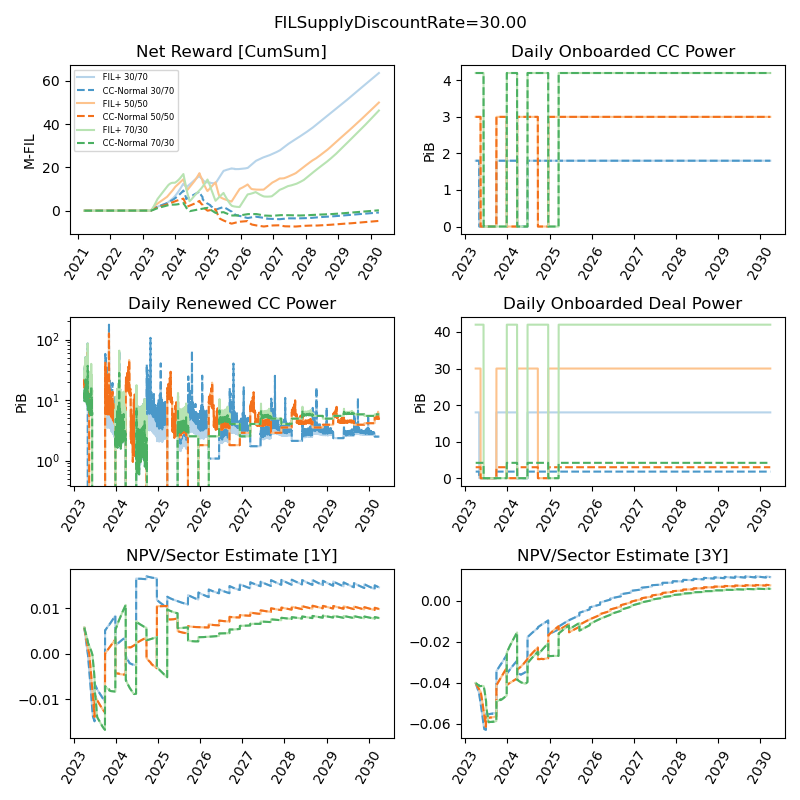

In [91]:
plt.figure(figsize=(8,8))

plt_kwargs_list = [
    [{'color': blues(0.3)}, {'color': blues(0.6), 'linestyle':'--'}, {'color': blues(0.8), 'linestyle':':'}],
    [{'color': oranges(0.3)}, {'color': oranges(0.6), 'linestyle':'--'}, {'color': oranges(0.8), 'linestyle':':'}],
    [{'color': greens(0.3)}, {'color': greens(0.6), 'linestyle':'--'}, {'color': greens(0.8), 'linestyle':':'}],
]
per_agent_label_list = ['FIL+', 'CC-Normal', 'CC-RiskAverse']

plt.subplot(3,2,1)
keys = ['reward_FIL', 'pledge_interest_payment_FIL']
def compute_net_reward_FIL(key_data):
    net_reward_FIL = key_data['reward_FIL'].cumsum() - key_data['pledge_interest_payment_FIL'].cumsum()
    return net_reward_FIL/1_000_000
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_agent(keys, e,
               x_post_process=x_post_fn,
               y_post_process=compute_net_reward_FIL, 
               df_name='accounting_df', 
               label_postpend=exp_name, 
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii]
              )
plt.title('Net Reward [CumSum]')
plt.ylabel('M-FIL')
plt.legend(fontsize=6)

plt.subplot(3,2,2)
keys = ['cc_onboarded', 'cc_renewed', 'deal_onboarded']
def compute_cc_onboards(key_data):
    total_onboards = key_data['cc_onboarded']
    return total_onboards
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_agent(keys, e,
               x_post_process=x_post_fn,
               y_post_process=compute_cc_onboards, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii]
              )
plt.title('Daily Onboarded CC Power')
plt.ylabel('PiB')
# plt.legend(fontsize=4)

plt.subplot(3,2,3)
def compute_cc_renews(key_data):
    total_onboards = key_data['cc_renewed']
    return total_onboards
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_agent(keys, e,
               x_post_process=x_post_fn,
               y_post_process=compute_cc_renews, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii]
              )
plt.title('Daily Renewed CC Power')
plt.ylabel('PiB')
plt.yscale('log')

plt.subplot(3,2,4)
def compute_deal_onboarded(key_data):
    total_onboards = key_data['deal_onboarded']
    return total_onboards
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_agent(keys, e,
               x_post_process=x_post_fn,
               y_post_process=compute_deal_onboarded, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii]
              )
plt.title('Daily Onboarded Deal Power')
plt.ylabel('PiB')

plt.subplot(3,2,5)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_agent(['npv_estimate_365'], e,
               x_post_process=x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii]
              )
plt.title('NPV/Sector Estimate [1Y]')

plt.subplot(3,2,6)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_agent(['npv_estimate_1095'], e,
               x_post_process=x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii]
              )
plt.title('NPV/Sector Estimate [3Y]')

# plt.subplot(3,2,6)
# for ii, e in enumerate(experiment_dirs):
#     exp_name = experiment_names[ii]
#     plot_agent(['cc_onboarded_duration'], e,
#                x_post_process=x_post_fn,
#                y_post_process=None, 
#                df_name='agent_info_df', 
#                label_postpend=exp_name,  
#                per_agent_label_list=per_agent_label_list,
#                plot_kwargs_list=plt_kwargs_list[ii]
#               )
# plt.title('Sector Duration')


plt.suptitle('FILSupplyDiscountRate=%0.02f' % \
             (fil_supply_discount_rate,))

plt.tight_layout()

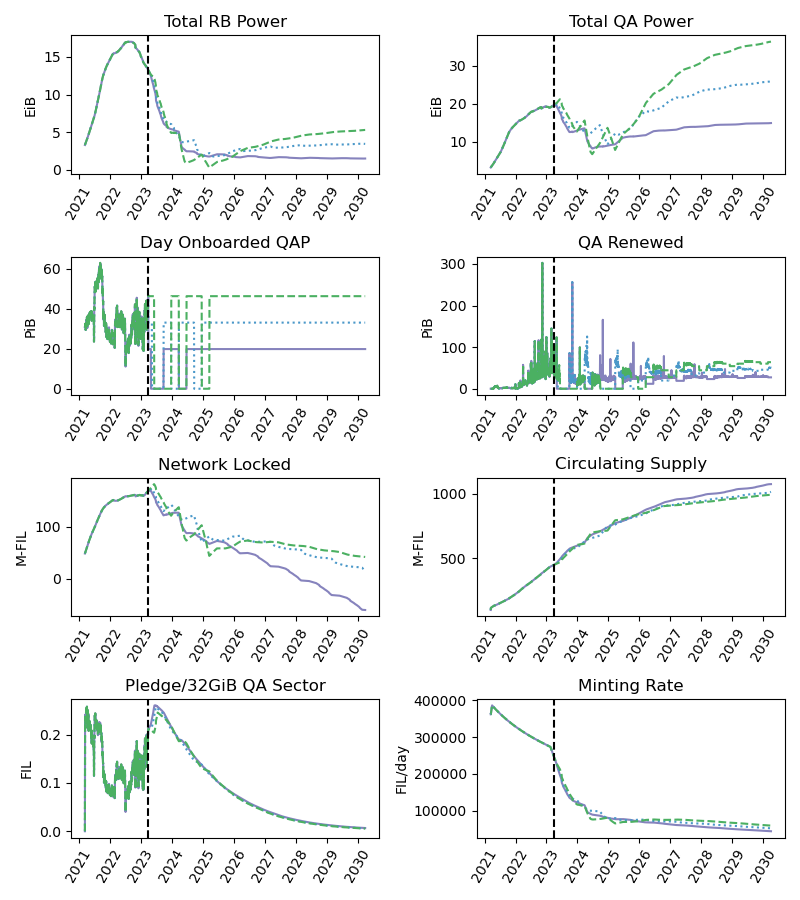

In [90]:
# plot the econometric panel
def converttoMFIL(x): return x/1e6

plt_kwargs_list = [
    {'color': purples(0.6)}, 
    {'color': blues(0.6), 'linestyle': ':', },
    {'color': greens(0.6), 'linestyle': '--'}, 
    {'color': oranges(0.6), 'linestyle': '--'}, 
    {'color': reds(0.6)}
]

plt.figure(figsize=(8,9))

plt.subplot(4,2,1)
plot_experiments(['total_raw_power_eib'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Total RB Power')
plt.ylabel('EiB')


plt.subplot(4,2,2)
plot_experiments(['total_qa_power_eib'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Total QA Power')
plt.ylabel('EiB')
    
plt.subplot(4,2,3)
plot_experiments(['day_onboarded_qap_pib'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Day Onboarded QAP')
plt.ylabel('PiB')

plt.subplot(4,2,4)
plot_experiments(['day_renewed_qap_pib'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('QA Renewed')
plt.ylabel('PiB')

plt.subplot(4,2,5)
plot_experiments(['network_locked'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=converttoMFIL,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Network Locked')
plt.ylabel('M-FIL')

plt.subplot(4,2,6)
plot_experiments(['circ_supply'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=converttoMFIL,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Circulating Supply')
plt.ylabel('M-FIL')


plt.subplot(4,2,7)
plot_experiments(['day_pledge_per_QAP'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Pledge/32GiB QA Sector')
plt.ylabel('FIL')


plt.subplot(4,2,8)
plot_experiments(['day_network_reward'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Minting Rate')
plt.ylabel('FIL/day')


# plt.subplot(4,2,8)
# plot_experiments(['discount_rate_pct'], experiment_dirs, 
#                  x_post_process=x_post_fn, 
#                  y_post_process=None,
#                  x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=plt_kwargs_list)
# plt.axvline(date(2023,4,1), linestyle='--', color='k')
# plt.title('FIL Supply Discount Rate')
# plt.ylabel('%')

plt.tight_layout()